# Cross Validation
>
> Lei Xue

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pylab as plt
%matplotlib inline 

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score, recall_score, f1_score

In [2]:
df= pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
df['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
random_state =  np.random.RandomState(42)
X = df.iloc[:, 0:8].values
print(X.shape)
print(type(X))

(768, 8)
<class 'numpy.ndarray'>


In [6]:
Y = df.iloc[:, 8].values
print(Y.shape)
print(type(Y))

(768,)
<class 'numpy.ndarray'>


### Model Split

In [7]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.2, random_state=random_state)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(614, 8) (614,)
(154, 8) (154,)


In [8]:
unique_elements, counts_elements = np.unique(Y_train, return_counts=True)
print(unique_elements)
print(counts_elements)

[0 1]
[401 213]


In [9]:
unique_elements, counts_elements = np.unique(Y_test, return_counts=True)
print(unique_elements)
print(counts_elements)

[0 1]
[99 55]


### Feature Selection

In [10]:
from sklearn.feature_selection import SelectKBest, chi2

In [11]:
ch2 = SelectKBest(chi2, k=5) 
X_train = ch2.fit_transform(X_train, Y_train)
X_test = ch2.transform(X_test)

In [12]:
print(X_train.shape)
print(X_test.shape)

(614, 5)
(154, 5)


In [13]:
cols = ch2.get_support(indices=True)
df.iloc[:,cols].columns

Index(['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age'], dtype='object')

### Feature Scaling

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### k-Nearest Neighbors (k-NN)

In [24]:
from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

### Tuning Hyperparameters

In [107]:
df_knn = pd.DataFrame(columns= ['neighbors','weight', 'accuracy', 'F1', 'ROC_area'])

for neighbor_count in range (1,6):
    for weight_metric in ['uniform', 'distance']:    
        knn_ht = KNeighborsClassifier(n_neighbors=neighbor_count, weights=weight_metric) # initialize a KNN classifier
        knn_ht.fit(X_train, Y_train)

        Y_pred_prob_ht = knn_ht.predict_proba(X_test)[:, 1]
       
        accuracy = knn_ht.score(X_test,Y_test)
        f1 = f1_score(Y_test,knn_ht.predict(X_test),average='weighted')
        roc = roc_auc_score(Y_test, Y_pred_prob_ht)       
        
        dict_values = {'neighbors': neighbor_count, 'weight': weight_metric,'accuracy':accuracy,'F1' : f1, 'ROC_area':roc}
        row_to_add = pd.Series(dict_values)
        
        df_knn = df_knn.append(row_to_add, ignore_index=True)

df_knn.set_index(['neighbors','weight'], inplace=True)
df_knn

accuracy        F1  ROC_area
neighbors weight                                
1         uniform   0.688312  0.691502  0.672727
          distance  0.688312  0.691502  0.672727
2         uniform   0.694805  0.681457  0.692011
          distance  0.688312  0.691502  0.701561
3         uniform   0.681818  0.684614  0.722314
          distance  0.681818  0.684614  0.726814
4         uniform   0.714286  0.702886  0.766942
          distance  0.688312  0.690567  0.763177
5         uniform   0.714286  0.713069  0.775482
          distance  0.727273  0.724827  0.775574

### Cross Validation

In [132]:
for x in range(1,8):
    for y in ['uniform', 'distance']:
        knn_cv = KNeighborsClassifier(n_neighbors=x, weights= y)
        scores_accuracy =  cross_val_score(knn_cv, X_train, Y_train, cv=5, scoring = 'accuracy')
        scores_f1_macro =  cross_val_score(knn_cv, X_train, Y_train, cv=5, scoring = 'f1_macro')
        metrics = ['f1_macro', 'precision_macro', 'recall_macro', ]
        scores_multiple = cross_validate(knn_cv, X_train, Y_train, cv=5, scoring = metrics)
        sorted(scores_multiple.keys())  
        print(x, y)       
        print('Avg. Precision:', scores_multiple['test_precision_macro'].mean())   
        print('Avg. Recall:', scores_multiple['test_recall_macro'].mean())    
        print('Avg. f1:', scores_multiple['test_f1_macro'].mean())
        x += 1

1 uniform
Avg. Precision: 0.6597899495668008
Avg. Recall: 0.6553149481153356
Avg. f1: 0.6564490366753027
2 distance
Avg. Precision: 0.6597899495668008
Avg. Recall: 0.6553149481153356
Avg. f1: 0.6564490366753027
2 uniform
Avg. Precision: 0.6685581760930628
Avg. Recall: 0.614478794963291
Avg. f1: 0.6152256248647837
3 distance
Avg. Precision: 0.7037351678607231
Avg. Recall: 0.6986004470694394
Avg. f1: 0.7004265713825522
3 uniform
Avg. Precision: 0.7055424208586947
Avg. Recall: 0.6999058180550428
Avg. f1: 0.7018685642312456
4 distance
Avg. Precision: 0.6958395656530246
Avg. Recall: 0.6902166646158895
Avg. f1: 0.6920340248359075
4 uniform
Avg. Precision: 0.7235082481427985
Avg. Recall: 0.6775443993273452
Avg. f1: 0.6871552820322243
5 distance
Avg. Precision: 0.7255460468942436
Avg. Recall: 0.7190427997210943
Avg. f1: 0.7214881263343573
5 uniform
Avg. Precision: 0.7235926320848213
Avg. Recall: 0.716772589311349
Avg. f1: 0.7193507133484305
6 distance
Avg. Precision: 0.7233806255789569
Avg. Re

**After trying the model a lot of times manully, I chose weight number = 5, weights = 'distance'**

### Report-- Confusion Marix

In [133]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, weights='distance') 
knn.fit(X_train, Y_train) 

KNeighborsClassifier(weights='distance')

In [135]:
Y_train_predicted = knn.predict(X_train) 

In [136]:
print("Training Classification accuracy:", knn.score(X_train, Y_train))
print("\n")
print ("Training Confusion matrix: \n" + str(confusion_matrix(Y_train, Y_train_predicted)))
print("\n")
print("Training Classification Report:\n",classification_report(Y_train, Y_train_predicted))

Training Classification accuracy: 1.0


Training Confusion matrix: 
[[401   0]
 [  0 213]]


Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       401
           1       1.00      1.00      1.00       213

    accuracy                           1.00       614
   macro avg       1.00      1.00      1.00       614
weighted avg       1.00      1.00      1.00       614



In [137]:
Y_test_predicted = knn.predict(X_test)
conf_matrix_knn = confusion_matrix(Y_test, Y_test_predicted)
print('************K-NEAREST NEIGHBOR************')
print("Test Classification accuracy:", knn.score(X_test,Y_test))
print("\n")
print ("Test Confusion matrix: \n" + str(conf_matrix_knn))
print("\n")
print("Test Classification Report:\n",classification_report(Y_test, Y_test_predicted))

************K-NEAREST NEIGHBOR************
Test Classification accuracy: 0.7272727272727273


Test Confusion matrix: 
[[80 19]
 [23 32]]


Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.81      0.79        99
           1       0.63      0.58      0.60        55

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.70       154
weighted avg       0.72      0.73      0.72       154



In [138]:
from sklearn.metrics import plot_confusion_matrix

[[80 19]
 [23 32]]


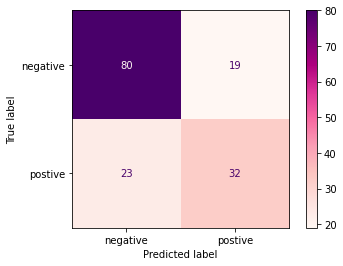

In [139]:
disp = plot_confusion_matrix(knn, X_test, Y_test,
                                 display_labels=['negative','postive'],
                                 cmap=plt.cm.RdPu,
                                 normalize=None)
print(disp.confusion_matrix)

### Report -----ROC Curve

Area under the ROC: 0.7755739210284665


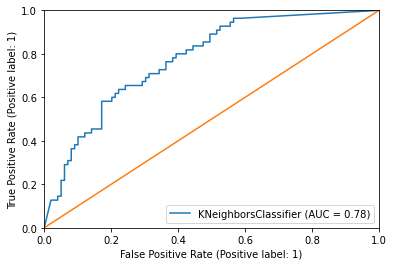

In [140]:
viz = plot_roc_curve(knn, X_test, Y_test)
print('Area under the ROC:', viz.roc_auc)   
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.show();